<h1>Import</h1>

In [4]:
import pandas as pd
from sodapy import Socrata

MyAppToken = 'xxxxxxxx'
client = Socrata('data.cityofnewyork.us',
                  MyAppToken,
                  username="me@email.com",
                  password="password_text")

In [5]:
#https://data.cityofnewyork.us/Public-Safety/Civilian-Complaint-Review-Board-CCRB-Complaints-Re/63nx-cpi9
complaints_received = pd.DataFrame.from_records(client.get("63nx-cpi9", limit=310000))

#https://data.cityofnewyork.us/Public-Safety/Civilian-Complaint-Review-Board-CCRB-Complaints-Cl/fx4z-5xg2
complaints_closed = pd.DataFrame.from_records(client.get("fx4z-5xg2", limit=310000))

#https://data.cityofnewyork.us/Public-Safety/Civilian-Complaint-Review-Board-CCRB-Allegations-C/xyq2-jjkn
allegations_closed = pd.DataFrame.from_records(client.get("xyq2-jjkn", limit=310000))

<h1>Structure Data</h1>

In [6]:
allegations_closed['outcome'] = [i =='Miscellaneous - Subject Terminated' for i in allegations_closed['allegation_disposition']]
allegations_closed['force'] = allegations_closed['allegation_fado_type'] == "Force"
allegations_closed['inv'] = allegations_closed['allegation_outcome_path'] == "Full Investigation"

af = allegations_closed.groupby("uniquerandomcomplaintid")["force"].sum()
ao = allegations_closed.groupby("uniquerandomcomplaintid")["outcome"].sum()
ai = allegations_closed.groupby("uniquerandomcomplaintid")["inv"].sum()

complaints_received.rename(columns={'randomized_id':'uniquerandomcomplaintid'}, inplace=True)

from functools import reduce
data_frames = [complaints_received, af, ao, ai]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['uniquerandomcomplaintid'],
                                            how='left'), data_frames)

<h1>Print High Level Data</h1>

In [7]:
complaints_data = df_merged[df_merged["force"]>0].count()["force"]
force_data = df_merged[df_merged["force"]>0]

force_investigations = force_data[force_data["inv"]>=1].count()["inv"]
full_investigations = force_data[force_data["inv"]>=force_data["force"]]

full_investigations_count = full_investigations["inv"].count()

force_investigations_outcomes = full_investigations[full_investigations["outcome"]>0].count()["outcome"]

print("Complaints of Excessive Force: ",complaints_data)
print("Complaints Investigated: ",force_investigations, ", ", "{:.2%}".format(force_investigations/complaints_data));
print("Complaints Fully Investigated: ",full_investigations_count, ", ","{:.2%}".format(full_investigations_count/complaints_data));
print("Complaints Resulting in Termination: ", force_investigations_outcomes, ", ", "{:.2%}".format(force_investigations_outcomes/complaints_data));

Complaints of Excessive Force:  52438
Complaints Investigated:  20017 ,  38.17%
Complaints Fully Investigated:  19487 ,  37.16%
Complaints Resulting in Termination:  23 ,  0.04%


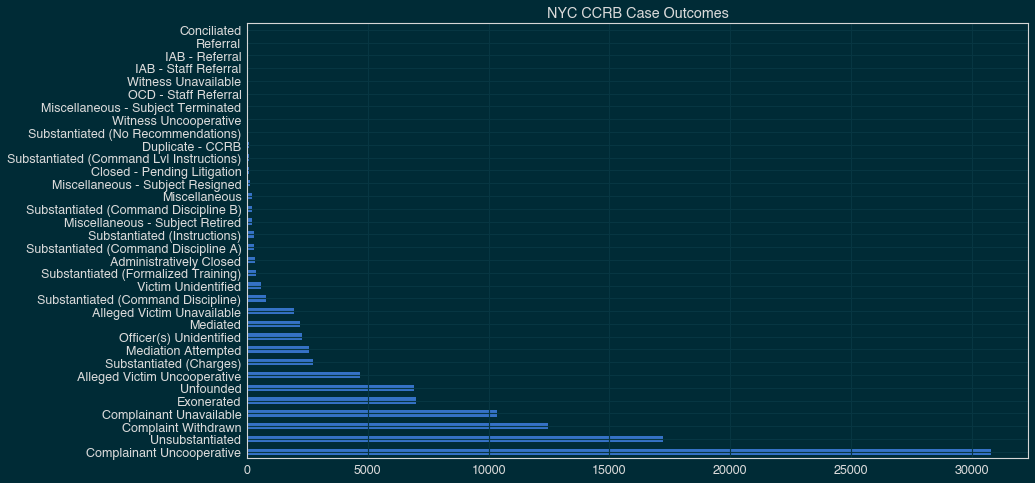

In [14]:
ax = complaints_closed['case_disposition'].value_counts().plot(kind='barh',
                                    figsize=(14,8),
                                    title="NYC CCRB Case Outcomes")
from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='solarizedd')

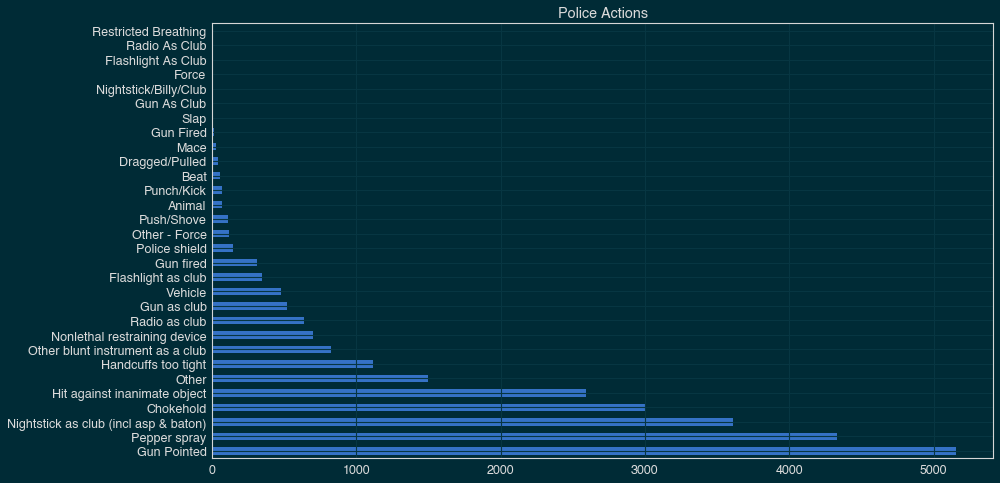

In [9]:
police_v = allegations_closed[(allegations_closed['allegation_fado_type'] == 'Force') & (allegations_closed['allegation'] != 'Physical force')]

ax = police_v['allegation'].value_counts().plot(kind='barh',
                                    figsize=(14,8),
                                    title="Police Actions")

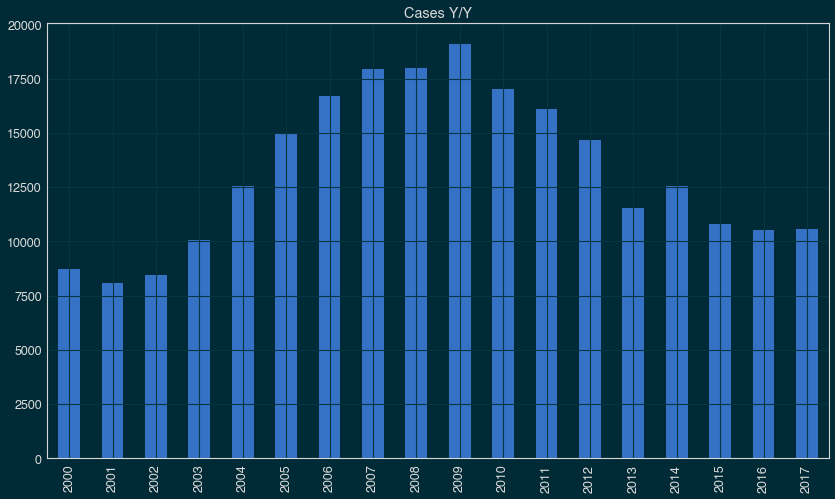

In [10]:
ax = df_merged['ccrb_received_year'].value_counts().sort_index().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Cases Y/Y")

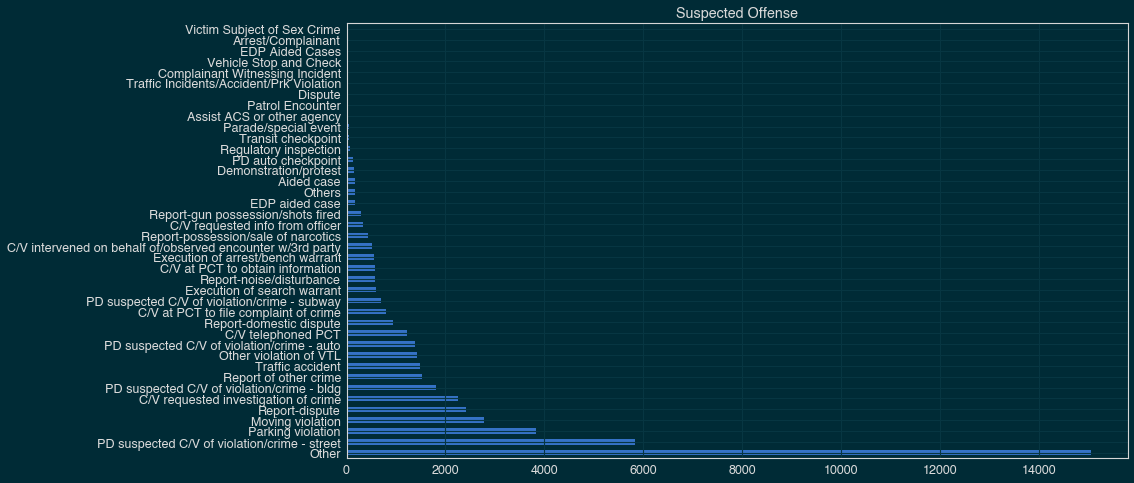

In [11]:
ax = force_data['reason_for_initial_contact'].value_counts().plot(kind='barh',
                                    figsize=(14,8),
                                    title="Suspected Offense")

In [12]:
#Negihbourhoods
#race
#sex
#age
#force breakout

In [13]:
df_merged

,extract_run_date,uniquerandomcomplaintid,ccrb_received_year,days_between_incident_date,case_type,complaint_received_place,complaint_received_mode,borough_of_incident,patrol_borough_of_incident,reason_for_initial_contact,force,outcome,inv
0,2018-05-25T00:00:00.000,1,2000,2,IAB,CCRB,Phone,Bronx,Bronx,PD suspected C/V of violation/crime - street,3.0,0.0,3.0
1,2018-05-25T00:00:00.000,2,2000,86,OCD,Other NYPD unit,In-person,Brooklyn,Brooklyn North,Parking violation,0.0,0.0,0.0
2,2018-05-25T00:00:00.000,3,2000,0,OCD,CCRB,Phone,Queens,Other,NaN,0.0,0.0,0.0
3,2018-05-25T00:00:00.000,4,2000,0,OCD,Other NYPD unit,Phone,Bronx,Bronx,NaN,1.0,0.0,3.0
4,2018-05-25T00:00:00.000,5,2000,117,OCD,CCRB,Phone,Manhattan,Manhattan North,Traffic accident,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238378,2018-05-25T00:00:00.000,238379,2017,20,CCRB,CCRB,Phone,Queens,Queens South,PD suspected C/V of violation/crime - auto,NaN,NaN,NaN
238379,2018-05-25T00:00:00.000,238380,2017,7,CCRB,IAB,Phone,Bronx,Bronx,PD suspected C/V of violation/crime - bldg,NaN,NaN,NaN
238380,2018-05-25T00:00:00.000,238381,2017,0,IAB,Mayor's Office,E-mail,NaN,Other,NaN,NaN,NaN,NaN
238381,2018-05-25T00:00:00.000,238382,2017,0,CCRB,CCRB,On-line website,Manhattan,Manhattan South,Other violation of VTL,NaN,NaN,NaN


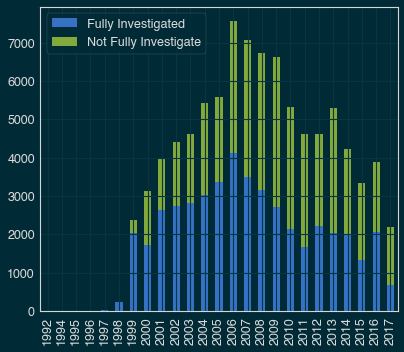

In [87]:
allegations_closed['recd_yr'] = pd.to_numeric(allegations_closed['closed_year']) - pd.to_numeric(allegations_closed['days_from_received_date_to']).div(365).round()
allegations_closed['recd_yr'] = allegations_closed['recd_yr'].astype(int)
h = allegations_closed[allegations_closed['allegation_fado_type'] == 'Force']

i_a = pd.Series(h[h['complaint_outcome_path'] == 'Full Investigation']['recd_yr'].value_counts(), name = 'Fully Investigated')
ni_a = pd.Series(h[h['complaint_outcome_path'] != 'Full Investigation']['recd_yr'].value_counts(), name = 'Not Fully Investigate')

pd.concat([i_a, ni_a],axis=1).sort_index().plot(kind="bar", stacked=True)



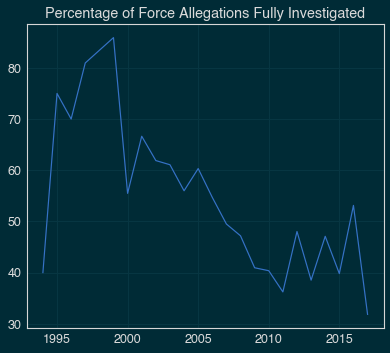

In [106]:
perc_inva = i_a/(ni_a+i_a)
perc_inv = perc_inva.drop(perc_inv.index[5])*100
perc_inv.plot(title="Percentage of Force Allegations Fully Investigated")